In [1]:
### https://anaconda.org/anaconda/py-xgboost
### Importando as libs
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
import pylab as pl
from sklearn import model_selection
from itertools import combinations
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Scripts

In [2]:
def seedAnalytcs(train,colunas,colunasy,teste_size):
    for seed_it in  range(1,15):
        print('SEED=',seed_it)
        x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed_it)
        x =x_treino.sort_values(by=['SaudacaoNum'])['SaudacaoNum'].unique()
        y=x_teste.sort_values(by=['SaudacaoNum'])['SaudacaoNum'].unique()
        print(x)
        print(y )
        print(y in x)

In [3]:
class Titanic:
    score=0
    colunas_final=[]
    max_depth_final=0
    seed_final=0
    acertos_final=0
    erros_final=0
    min_child_weight_final=0
    actuals=0
    predictions=0

In [4]:
def forward_feature_construction(colunasx,colunasy):
    size = len(colunasx)
    lista = list()
    for id in  range(1,size):
        for x in  combinations(colunasx,r=id):
            lista.append(list(x))
    return lista    

In [5]:
def print_titanic(resultado):
    print('#####################################################')
    print('################# RESULTADOS ########################')
    print('#####################################################')
    for titanic in resultado:
        print_titanic_valores(titanic)

In [6]:
def print_titanic_valores(titanic):
    print('Score =',titanic.score)
    print('acertos=',titanic.acertos_final)
    print('erros=',titanic.erros_final)
    print('colunas=',titanic.colunas_final)
    print('seed=',titanic.seed_final)
    print('max_depth_final=',titanic.max_depth_final)
    print('min_child_weight_final=',titanic.min_child_weight_final)
    print(confusion_matrix(titanic.actuals, titanic.predictions))
    print('#####################################################')

In [7]:
def predict(lista, train, colunasy,teste_size,scan):
   
    ### Config Default
    colunasx_it=['Classe','FamiliaQtde','PassagemPreco','SexoNum','SaudacaoNum']
    seed = 9
    max_depth=3
    min_child_weight=1
    
    ### Inicializando variáveis
    seed_it = seed
    max_depth_it=max_depth
    min_child_weight_it=min_child_weight
    colunasx_it=colunasx_it
    ultimo_acerto=0
    
    ### Config Final
    resultado = []
          
    if scan:
        for colunasx_it in  lista:
            ### Slice
            x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunasx_it],train[colunasy],test_size=teste_size,random_state=seed_it)
            ### Modelo - Treino
            xgb_model = xgb.XGBClassifier(max_depth=max_depth_it,min_child_weight=min_child_weight_it).fit(x_treino, y_treino)
            ### Modelo - Predict
            predictions = xgb_model.predict(x_teste)
            ### Confusion Matrix
            actuals = y_teste
            #print(colunasx)
            previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
            resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
            resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
            pontuacao=(xgb_model.score(x_teste,y_teste)*100.0)

            if resultadoAcertos.size >= ultimo_acerto and pontuacao >84 :
                if(resultadoAcertos.size>ultimo_acerto):
                    resultado=[]
                titanic = Titanic()
                ### Score
                titanic.score = pontuacao
                ### Resultado Final
                titanic.max_depth_final=max_depth_it
                titanic.seed_final=seed_it
                titanic.colunas_final=colunasx_it
                titanic.acertos_final=resultadoAcertos.size
                titanic.erros_final=resultadoErros.size
                titanic.min_child_weight_final=min_child_weight
                titanic.actuals=actuals
                titanic.predictions=predictions
                
                resultado.append(titanic)
                ultimo_acerto=resultadoAcertos.size
                
                

    else:
        ### Slice
        x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed)
        ### Modelo - Treino
        xgb_model = xgb.XGBClassifier(max_depth=max_depth,min_child_weight=min_child_weight).fit(x_treino, y_treino)
        ### Modelo - Predict
        predictions = xgb_model.predict(x_teste)
        ### Score
        score = xgb_model.score(x_teste,y_teste)
        actuals = y_teste
        previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
        resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
        resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
        ### Resultado Final
        max_depth_final=max_depth
        seed_final=seed
        colunas_final=colunas
        acertos_final=resultadoAcertos.size
        min_child_weight_final=min_child_weight
    print_titanic(resultado)
    return resultado


    

# Coleta de dados

## Fontes

In [8]:
### Coletando as fontes de dados
test_csv = pd.read_csv('r_teste.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_csv = pd.read_csv('r_treino.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_dropna_csv = pd.read_csv('r_treino_dropna.csv', sep = ',', encoding = 'UTF-8',header='infer')

In [9]:
colunasx=[
    'Classe',
    #'FaixaEtaria',
    #'PortoEmbarqueNum',
    #'ParentesIrmao',
    'ParentesFilhos',
    'SexoNum',
    'SaudacaoNum',
    'PassagemPreco',
    'FamiliaQtde',
    'EstaSozinho',
    'TemCabine'
]
colunasy=['Sobreviventes']

In [10]:
colunas = forward_feature_construction(colunasx,colunasy)

In [11]:
#train= train_dropna_csv
train= train_csv
train=train.set_index(train['PassageiroId'])

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 14 columns):
PassageiroId        891 non-null int64
Idade               714 non-null float64
FaixaEtaria         714 non-null float64
Classe              891 non-null int64
PortoEmbarqueNum    891 non-null int64
ParentesIrmao       891 non-null int64
ParentesFilhos      891 non-null int64
SexoNum             891 non-null int64
SaudacaoNum         891 non-null int64
PassagemPreco       891 non-null float64
FamiliaQtde         891 non-null int64
EstaSozinho         891 non-null float64
TemCabine           891 non-null float64
Sobreviventes       891 non-null int64
dtypes: float64(5), int64(9)
memory usage: 104.4 KB


In [13]:
### Config
teste_size=0.30 ##30%

In [14]:
resultado=predict(colunas, train, colunasy,teste_size,True)
#84.18604651162791

#####################################################
################# RESULTADOS ########################
#####################################################


# Tuning

In [15]:
param_teste1 = {
 #'max_depth':np.arange(3,10,2),#Quantidade máxima de itens na extensão
 #'min_child_weight':np.arange(1,60,2),
 #'n_estimators':[100,500,1000],
 #'seed':np.arange(1,25,1),
 #'learning_rate':[0.1,0.2,0.3,0.5,1.0],#Taxa de aprendizado
 'max_depth':[3],
 'seed':[9],
 'min_child_weight': [1],
}

## Slice

In [16]:
colunas= ['Classe', 'SexoNum', 'SaudacaoNum', 'PassagemPreco', 'FamiliaQtde']

In [17]:
c, r = train[colunasy].shape
y_treino = train[colunasy].values.reshape(c,)

In [18]:
xgb_model = xgb.XGBClassifier()
gsearch1 = GridSearchCV(xgb_model, param_grid = param_teste1, scoring='roc_auc',n_jobs=4,iid=False, cv=100)
gsearch1.fit(train[colunas],y_treino)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.87969, std: 0.13888, params: {'max_depth': 3, 'min_child_weight': 1, 'seed': 9}],
 {'max_depth': 3, 'min_child_weight': 1, 'seed': 9},
 0.8796944444444442)

## Modelo

In [19]:
best_est = gsearch1.best_estimator_
best_est

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=9, silent=True,
       subsample=1)

# Relatório Kaggle

## Previsões Final

In [20]:
y_test = best_est.predict(test_csv[colunas])

## Gerando CSV

In [21]:
submission = pd.DataFrame({
        "PassengerId": test_csv["PassageiroId"],
        "Survived": y_test
    })
submission.to_csv('resultado.csv', index=False)

## Árvore de Decisão

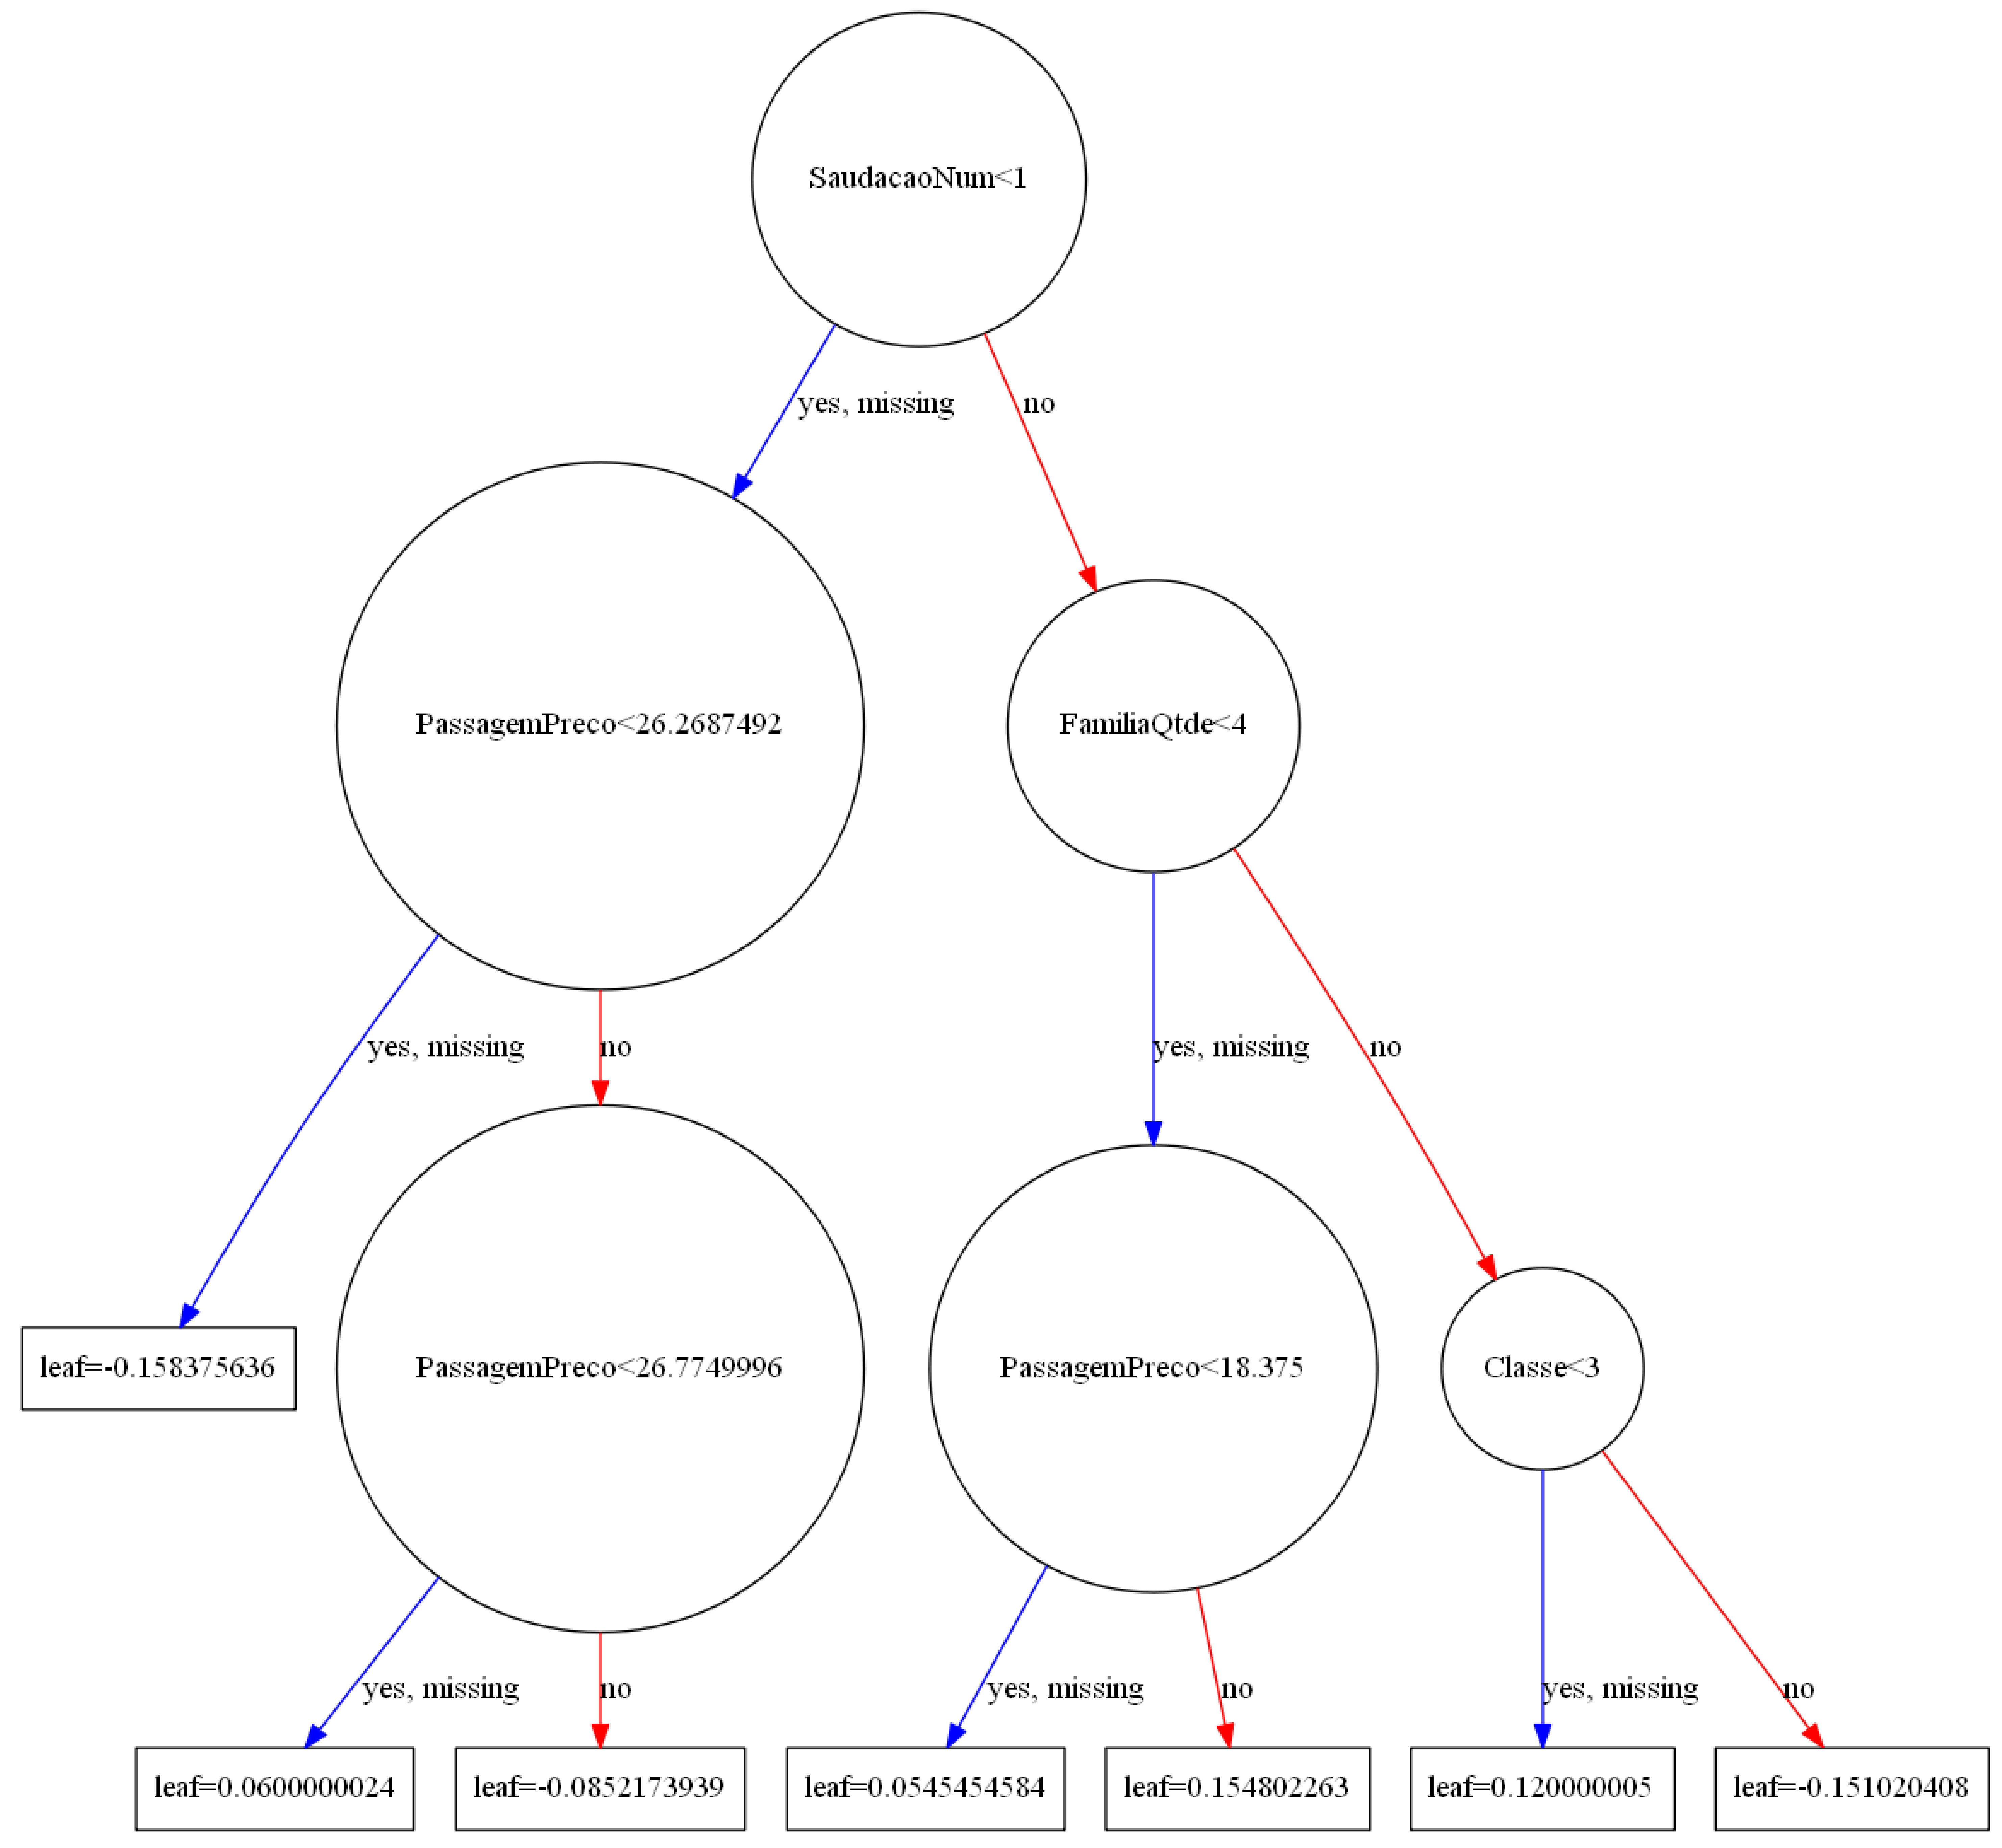

In [22]:
xgb.plot_tree(best_est)
fig = pl.gcf()
fig.set_size_inches(150, 100)